In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#installing catboost library
!pip install catboost

In [9]:
pip install shap

In [2]:
#importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import pickle

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, RocCurveDisplay
from sklearn import metrics

import shap

# Overview

Driving is an integral part of everyday life for many individuals. However, it's crucial to recognize that motor vehicle accidents remain a leading cause of death in America. Shockingly, there is a 1 in 107 chance of dying in a car crash.

# Business Proposition
In an effort to kickstart their comprehensive safety action plans aimed at mitigating the severity of vehicle accidents, the Department of Transportation (DOT) is seeking to identify the top three cities with the highest rate of severe crashes.



# Data
The original dataset included all states and DC expect for Alaska and Hawaii, comprising 7.7 millions recorded accidents. Given its scale, I focused exclusively on California, which registers the highest number of accidents.

For Data Cleaning, I removed irrelevant features such as 'Source', 'Country', 'Airport_Code', 'Timezone', and 'Wind_Direction'. To handle missing values in the Point of Interest columns, I imputed their respective mean values. Additionally, for categorical columns with null values, I chose to drop the corresponding rows.

In [3]:
#uploading the cleaned dataset
# cali_df = pd.read_csv('/content/drive/MyDrive/accidents/data/cali.csv')
cali_df = pd.read_csv('../data/cali.csv')

In [4]:
pd.set_option('display.max_columns', None)
cali_df.head()

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Duration,Month,Binary_Severity,Hour
0,728,A-729,3,2016-06-21 10:34:40,2016-06-21 11:04:40,38.085300,-122.233017,0.0,Right hand shoulder blocked due to accident on...,Magazine St,Vallejo,Solano,CA,94591,2016-06-21 10:54:00,75.0,64.73455,48.0,30.00,10.0,24.577115,0.008342,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,6,1,10
1,729,A-730,3,2016-06-21 10:30:16,2016-06-21 11:16:39,37.631813,-122.084167,0.0,Accident on I-880 Northbound at Exit 26 Tennys...,I-880 N,Hayward,Alameda,CA,94544,2016-06-21 10:54:00,75.0,64.73455,48.0,30.06,10.0,24.577115,0.008342,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.773056,6,1,10
2,730,A-731,2,2016-06-21 10:49:14,2016-06-21 11:19:14,37.896564,-122.070717,0.0,Right lane blocked due to accident on CA-24 We...,I-680 N,Walnut Creek,Contra Costa,CA,94595,2016-06-21 10:53:00,82.9,64.73455,31.0,29.97,10.0,24.577115,0.008342,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,6,0,10
3,731,A-732,3,2016-06-21 10:41:42,2016-06-21 11:11:42,37.334255,-122.032471,0.0,#4 &amp; HOV lane blocked due to accident on I...,N De Anza Blvd,Cupertino,Santa Clara,CA,95014,2016-06-21 10:56:00,75.9,64.73455,48.0,30.04,10.0,24.577115,0.008342,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,6,1,10
4,732,A-733,2,2016-06-21 10:16:26,2016-06-21 11:04:16,37.250729,-121.910713,0.0,Right hand shoulder blocked due to accident on...,Norman Y Mineta Hwy,San Jose,Santa Clara,CA,95118,2016-06-21 09:50:00,75.2,64.73455,41.0,30.06,10.0,24.577115,0.008342,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.797222,6,0,10


### Number of Accidents per Hour

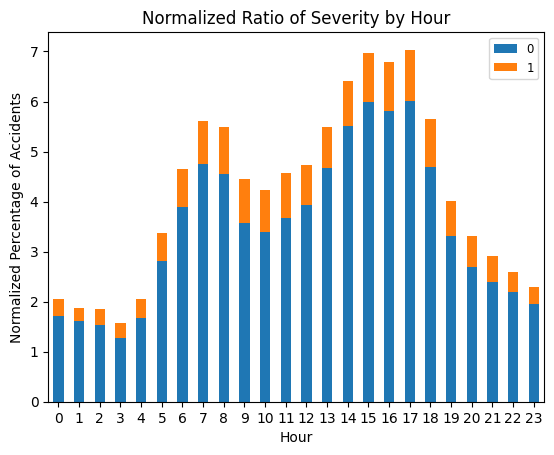

In [ ]:
# Calculate the total number of accidents across all hours
total_accidents = grouped_data_hour.sum().sum()

# Calculate the normalized values for each severity level in each hour
grouped_data_hour_normalized = grouped_data_hour.div(total_accidents) * 100

# Create a stacked bar plot
grouped_data_hour_normalized.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Hour')
plt.ylabel('Normalized Percentage of Accidents')
plt.title('Normalized Ratio of Severity by Hour')

# Rotate the x-axis labels
plt.xticks(rotation=360)

# Set the legend size
plt.legend(fontsize='small')

# Show the plot
plt.show()

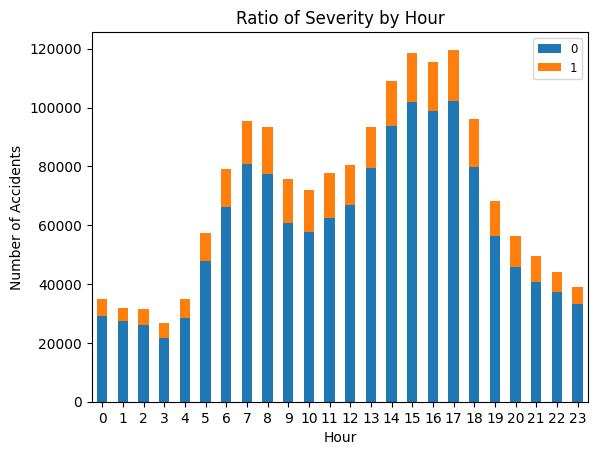

In [ ]:
# Select the relevant columns from the DataFrame
data_to_plot = cali_df[['Hour', 'Binary_Severity']]

# Group the data by 'Hour' and 'Binary_Severity' and count the occurrences
grouped_data = data_to_plot.groupby(['Hour', 'Binary_Severity']).size().unstack(fill_value=0)

# Sort the values by the sum of accidents in each hour of the day
hours = grouped_data.sum(axis=1).head(24).index

# Filter the grouped data to include all the hours
grouped_data_hour = grouped_data.loc[hours]

# Create a stacked bar plot
grouped_data_hour.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.title('Ratio of Severity by Hour')

# Rotate the x-axis labels
plt.xticks(rotation=360)

# Set the legend size
plt.legend(fontsize='small')

# Show the plot
plt.show();

We can see a big uptick in accidents during the morning/afternoon rush hour, coinciding with the times when most people are commuting.

As the number of accidents increases, the severity also appears to escalate.

### Number of Accidents per Month

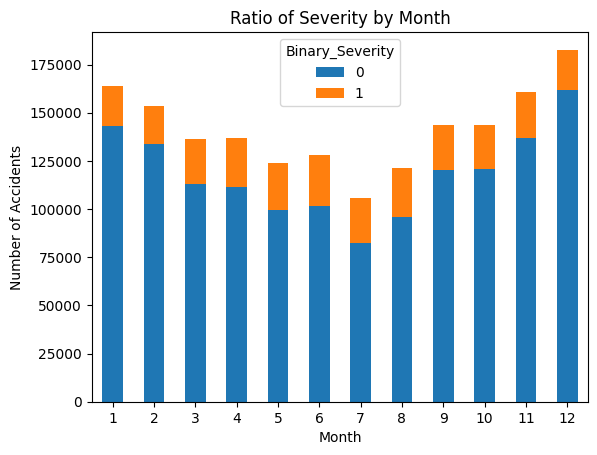

In [14]:
# Select the relevant columns from the DataFrame
data_to_plot = cali_df[['Month', 'Binary_Severity']]

# Group the data by 'Month' and 'Binary_Severity' and count the occurrences
grouped_data = data_to_plot.groupby(['Month', 'Binary_Severity']).size().unstack(fill_value=0)

# Sort the values by the sum of accidents in each month
month = grouped_data.sum(axis=1).head(12).index

# Filter the grouped data to include all the months
grouped_data_month = grouped_data.loc[month]

# Create a stacked bar plot
grouped_data_month.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Ratio of Severity by Month')

# Rotate the x-axis labels
plt.xticks(rotation=360)

# Show the plot
plt.show();

As observed, there is a surge in accidents towards the end of the year, aligning with increased holiday travel.

###  Number of Accidents per City

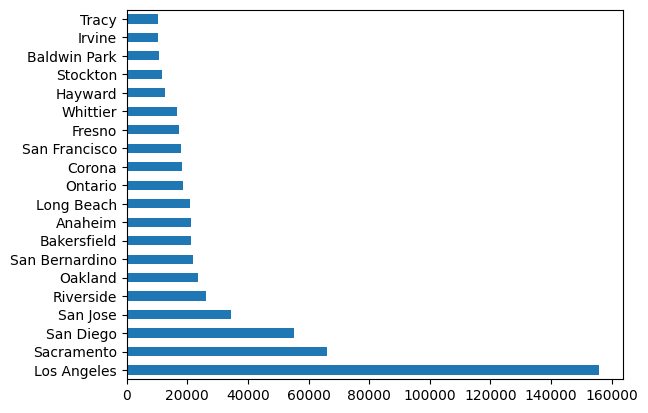

In [ ]:
#breakdown of the accidents by cities in California
cities_by_accident = cali_df.City.value_counts()
cities_by_accident[:20].plot(kind = 'barh'); #plotting the top 20 cities with the most accidents

We can see that Los Angeles has the highest number of accidents. Now let's see how many of those accidents were severe.

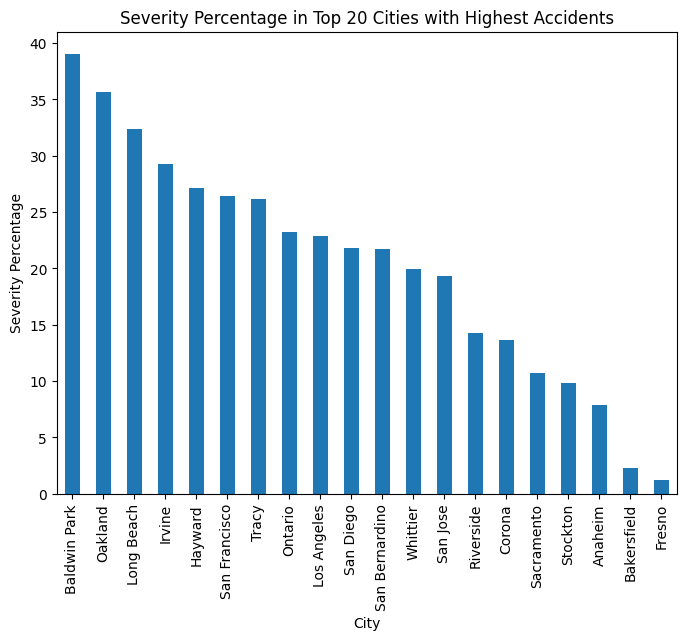

In [ ]:
#grouping the city by their binary_severity percentage
severity_percentage = cali_df.groupby('City')['Binary_Severity'].mean() * 100
accident_count = cali_df['City'].value_counts() #taking only the cities with the most accidents

# Combining severity percentage and accident count into a single dataframe
city_data = pd.DataFrame({'Severity Percentage': severity_percentage, 'Accident Count': accident_count})

# Sorting the cities by accident count in descending order and selecting the top 20 cities
top_20_cities = city_data.nlargest(20, 'Accident Count')

# Plotting the severity percentage for the top 20 cities in descending order
plt.figure(figsize=(8, 6))
top_20_cities['Severity Percentage'].sort_values(ascending=False).plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Severity Percentage')
plt.title('Severity Percentage in Top 20 Cities with Highest Accidents')
plt.xticks(rotation=90)
plt.show()

Surprisely, Los Angeles is ranked number 9 in severity. Baldwin Park has the highest percentage of severity.

### Ratio of Severity per Zipcode

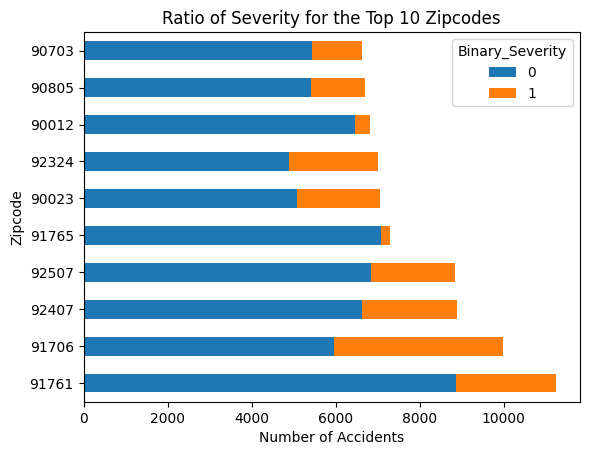

In [ ]:
# Select the relevant columns from the DataFrame
data_to_plot = cali_df[['Zipcode', 'Binary_Severity']]

# Group the data by 'Zipcode' and 'Binary_Severity' and count the occurrences
grouped_data = data_to_plot.groupby(['Zipcode', 'Binary_Severity']).size().unstack(fill_value=0)

# Sort the values by the sum of accidents in each zipcode and select the top 10 zipcodes
top_10_zipcodes = grouped_data.sum(axis=1).sort_values(ascending=False).head(10).index

# Filter the grouped data to include only the top 10 zipcode
grouped_data_top_10 = grouped_data.loc[top_10_zipcodes]

# Create a stacked bar plot
grouped_data_top_10.plot(kind='barh', stacked=True)

# Set the labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('Zipcode')
plt.title('Ratio of Severity for the Top 10 Zipcodes')

# Show the plot
plt.show();

The zipcode 91706 has the highest ratio of severe accidents. This zipcode corresponds to Baldwin Park, which aligns with our observations from the last plot.

### Presence of a Point of Interest (POI)

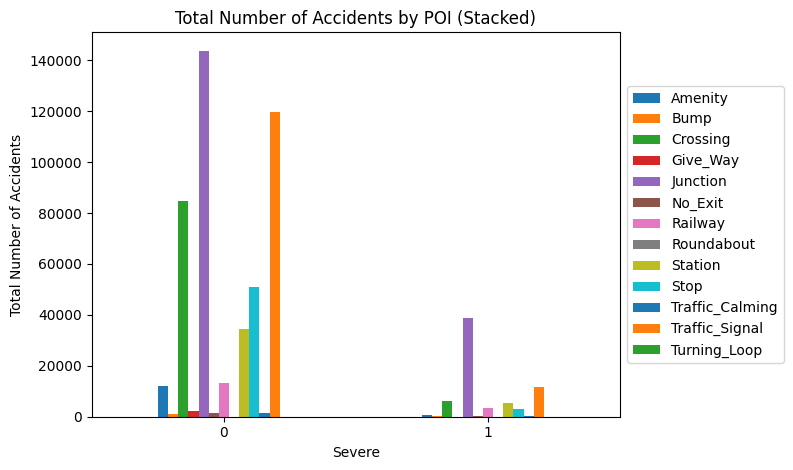

In [24]:
#plotting a stacked bar to show the severity class in each POI column
columns_to_plot = ["Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
                   "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]

# You can create a new DataFrame with just the binary columns
binary_df = cali_df[columns_to_plot]

# Calculate the total number of accidents for each POI and severity
grouped_df = binary_df.groupby(cali_df['Binary_Severity']).sum()

# Plotting a stacked bar chart
grouped_df.plot(kind='bar', stacked=False)

plt.xlabel("Severe")
plt.ylabel("Total Number of Accidents")
plt.title("Total Number of Accidents by POI (Stacked)")

plt.xticks(rotation=360)  # Rotate x-axis labels by 360 degrees
plt.tight_layout()  # Adjust spacing to prevent overlap

# Move the legend to the right side of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Junction, Traffic Signal, and Crossing has the highest number of severe accidents.

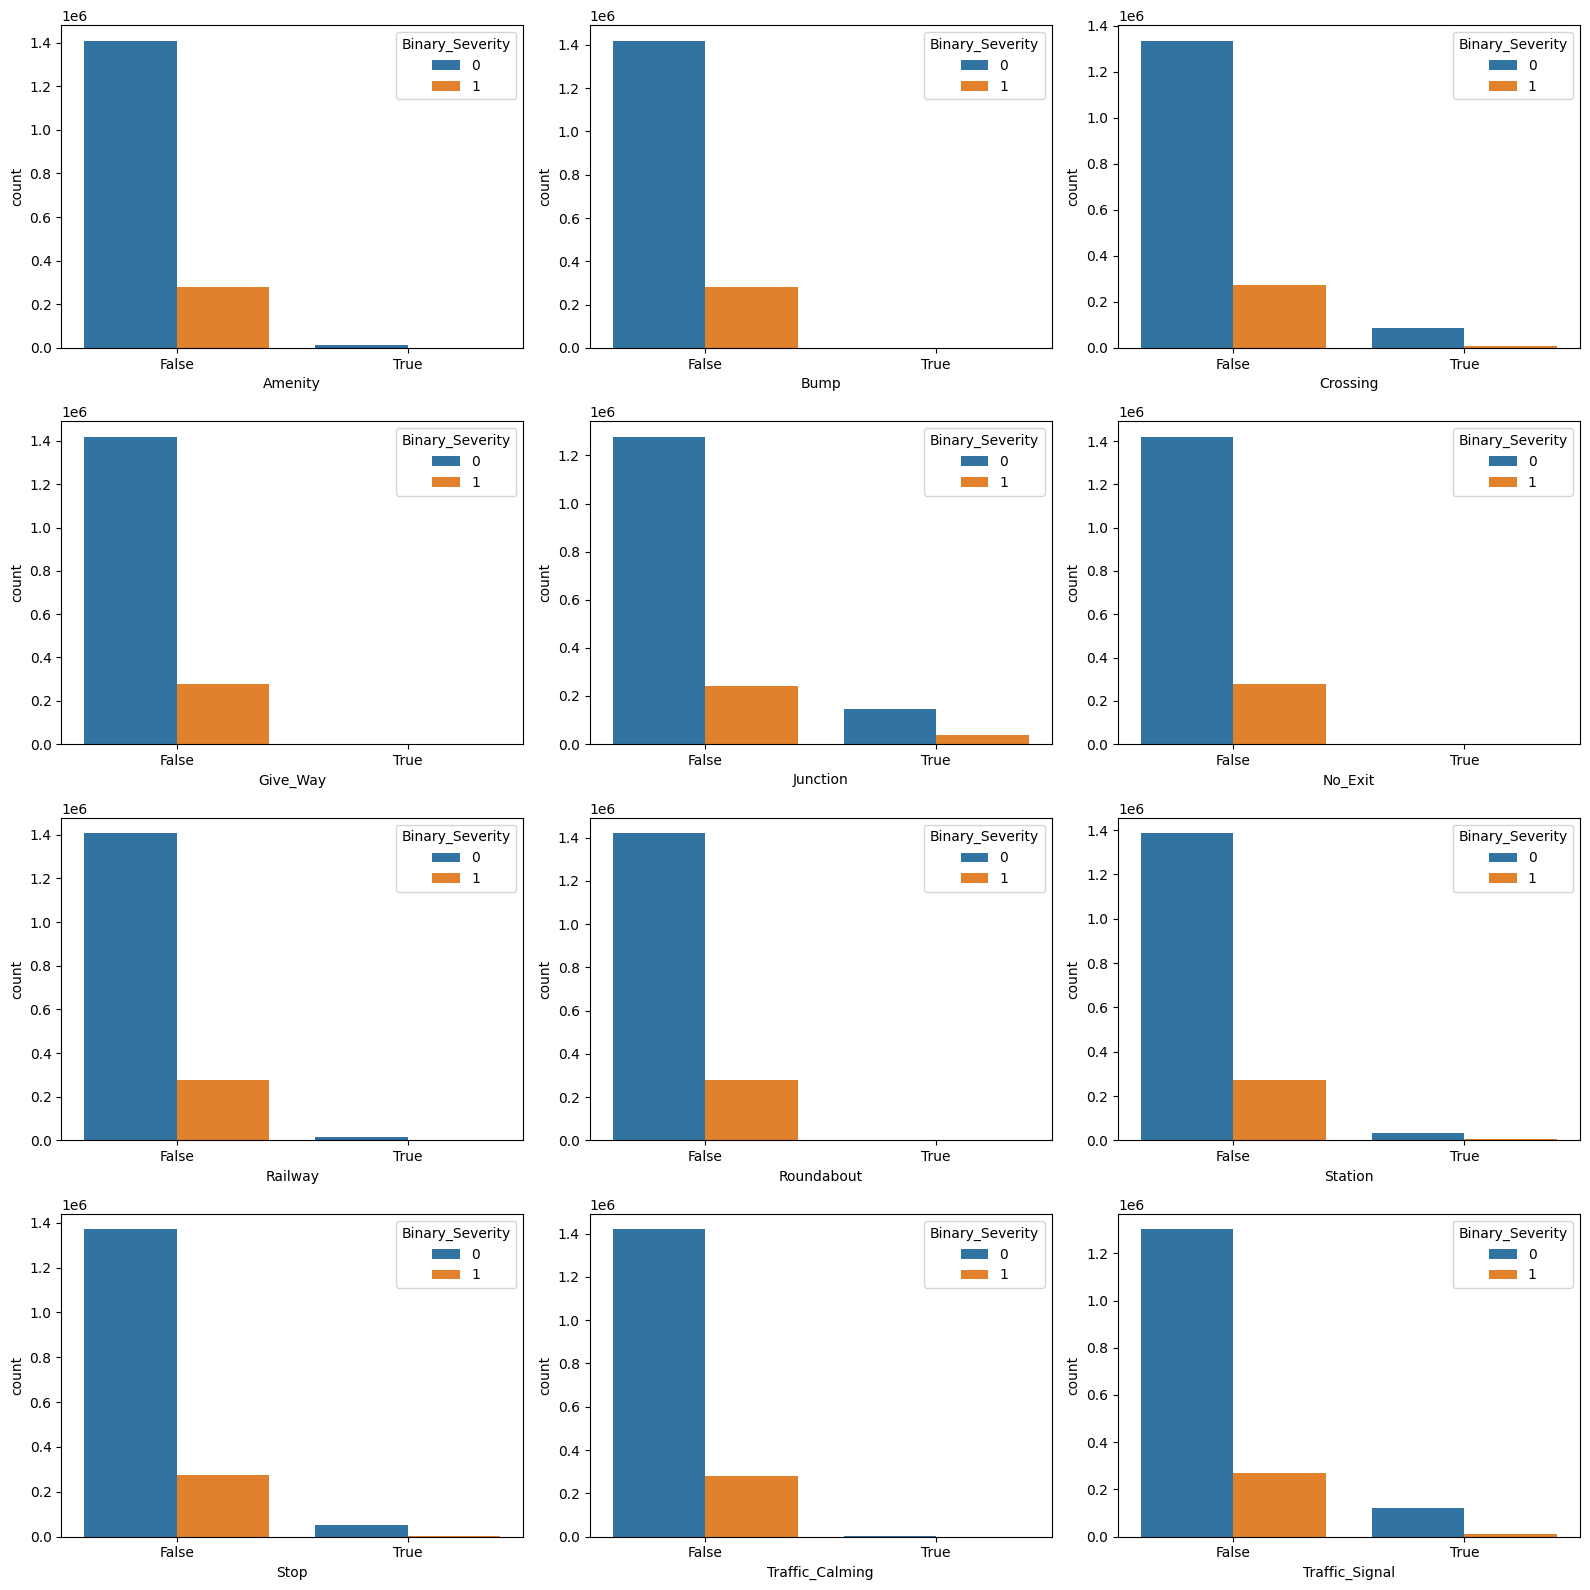

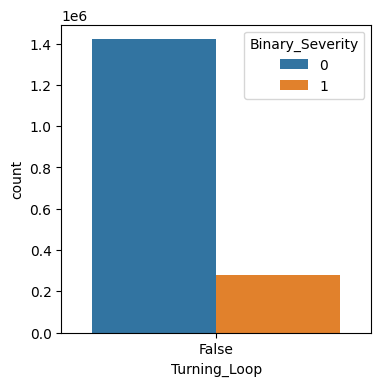

In [6]:
#plotting the severity class to each POI columns
fig, axes = plt.subplots(4, 3, figsize=(16, 16))

ax = sns.countplot(data=cali_df, x=cali_df["Amenity"], hue=cali_df['Binary_Severity'], ax=axes[0,0])
ax = sns.countplot(data=cali_df, x=cali_df["Bump"], hue=cali_df['Binary_Severity'], ax=axes[0,1])
ax = sns.countplot(data=cali_df, x=cali_df["Crossing"], hue=cali_df['Binary_Severity'], ax=axes[0,2])
ax = sns.countplot(data=cali_df, x=cali_df["Give_Way"], hue=cali_df['Binary_Severity'], ax=axes[1,0])
ax = sns.countplot(data=cali_df, x=cali_df["Junction"], hue=cali_df['Binary_Severity'], ax=axes[1,1])
ax = sns.countplot(data=cali_df, x=cali_df["No_Exit"], hue=cali_df['Binary_Severity'], ax=axes[1,2])
ax = sns.countplot(data=cali_df, x=cali_df["Railway"], hue=cali_df['Binary_Severity'], ax=axes[2,0])
ax = sns.countplot(data=cali_df, x=cali_df["Roundabout"], hue=cali_df['Binary_Severity'], ax=axes[2,1])
ax = sns.countplot(data=cali_df, x=cali_df["Station"], hue=cali_df['Binary_Severity'], ax=axes[2,2])
ax = sns.countplot(data=cali_df, x=cali_df["Stop"], hue=cali_df['Binary_Severity'], ax=axes[3,0])
ax = sns.countplot(data=cali_df, x=cali_df["Traffic_Calming"], hue=cali_df['Binary_Severity'], ax=axes[3,1])
ax = sns.countplot(data=cali_df, x=cali_df["Traffic_Signal"], hue=cali_df['Binary_Severity'], ax=axes[3,2])
plt.tight_layout()

plt.figure(figsize=(4, 4))
ax = sns.countplot(data=cali_df, x=cali_df["Turning_Loop"], hue=cali_df['Binary_Severity'])

plt.grid(False)
plt.show()

We can see that a majority of the accidents happened due to the absence of these road features.

### Accidents by Weather Condition

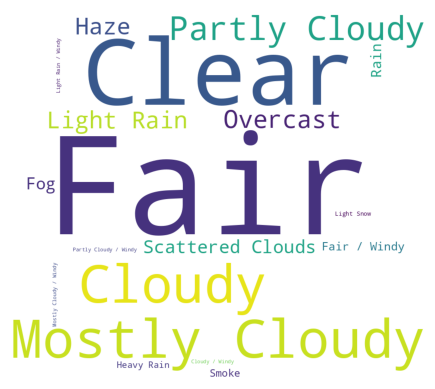

In [ ]:
#using a wordcloud to visual the frequency of each word from the weather condition column
data = cali_df['Weather_Condition'].value_counts().to_dict()
wc = WordCloud(width = 900, height = 800, background_color ='white', min_font_size = 10).generate_from_frequencies(data)
plt.imshow(wc)
plt.axis('off')
plt.show()

The majority of accidents occur under fair/clear or cloudy weather conditions rather than during snow or rain, which aligns with the typical weather conditions in California.

# Modeling
Due to the class imbalanced, I used the recall score as my performance metric. After tuning the parameters for all my models using RandomizedSearchCV and GridSearchCV, Catboost Classifier demonstrated the best performance.

In [15]:
#uploading the pickled catboost model
with open("/content/drive/MyDrive/accidents/data/tuned_cat.pkl", "rb") as f:
    tuned_cat_model = pickle.load(f)

In [16]:
#defining the predictor/target variables
X = cali_df.drop(columns=['Binary_Severity', 'Severity', 'State', 'Street', 'Weather_Timestamp',
                          'Start_Time', 'End_Time','Duration', 'ID', 'Unnamed: 0'], axis=1)
y = cali_df['Binary_Severity']

In [17]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [ ]:
#dont need to run this since we imported the pickle file
#want to show the parameters used for this model
# tuned_cat_model = CatBoostClassifier(cat_features=cat_features, auto_class_weights='Balanced', depth=16, iterations=130,
#                                learning_rate=0.15, task_type='GPU', random_state=88)

# tuned_cat_model.fit(X_train, y_train)

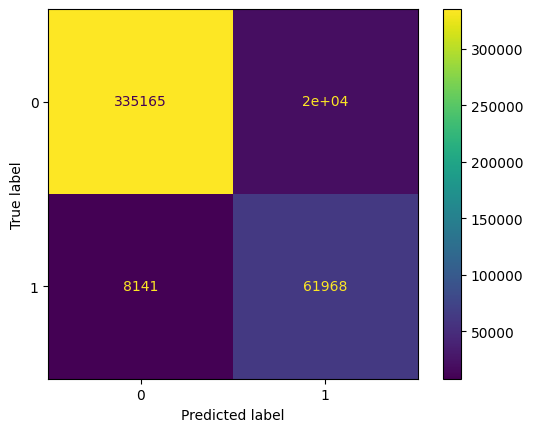

In [18]:
ConfusionMatrixDisplay.from_estimator(tuned_cat_model, X_test, y_test);

In [19]:
y_pred = tuned_cat_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9339625082017718

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    355104
           1       0.76      0.88      0.82     70109

    accuracy                           0.93    425213
   macro avg       0.87      0.91      0.89    425213
weighted avg       0.94      0.93      0.94    425213



It achieved a recall score of 94% for class 0 and 89% for class 1.

## Model Interpretation with SHAP

In [21]:
explainer = shap.Explainer(tuned_cat_model)

In [22]:
#using a subset of X_test
X_test_subset = X_test[:1000]

In [23]:
shap_values = explainer(X_test_subset)

In [24]:
shap_values.shape

(1000, 34)

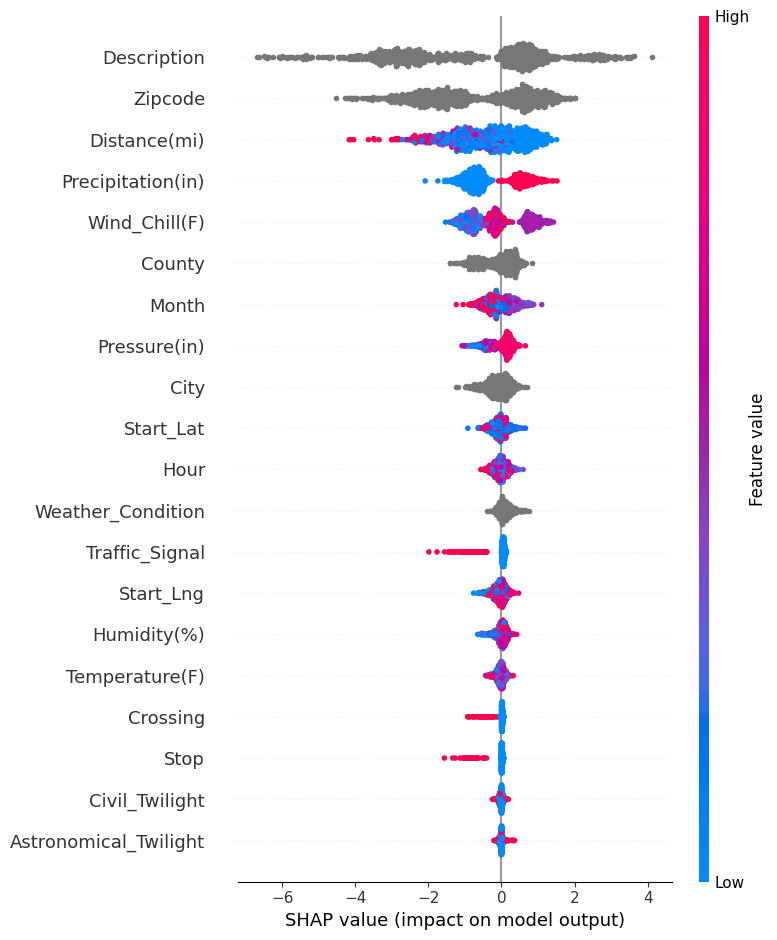

In [25]:
shap.summary_plot(shap_values, X_test_subset)

The model predicts higher SHAP value for severe accidents and a lower SHAP value for non-severe accidents. For Precipitation, it's evident that higher feature values correlate with more severe accidents, while the opposite trend can be observed for Traffic Signal.

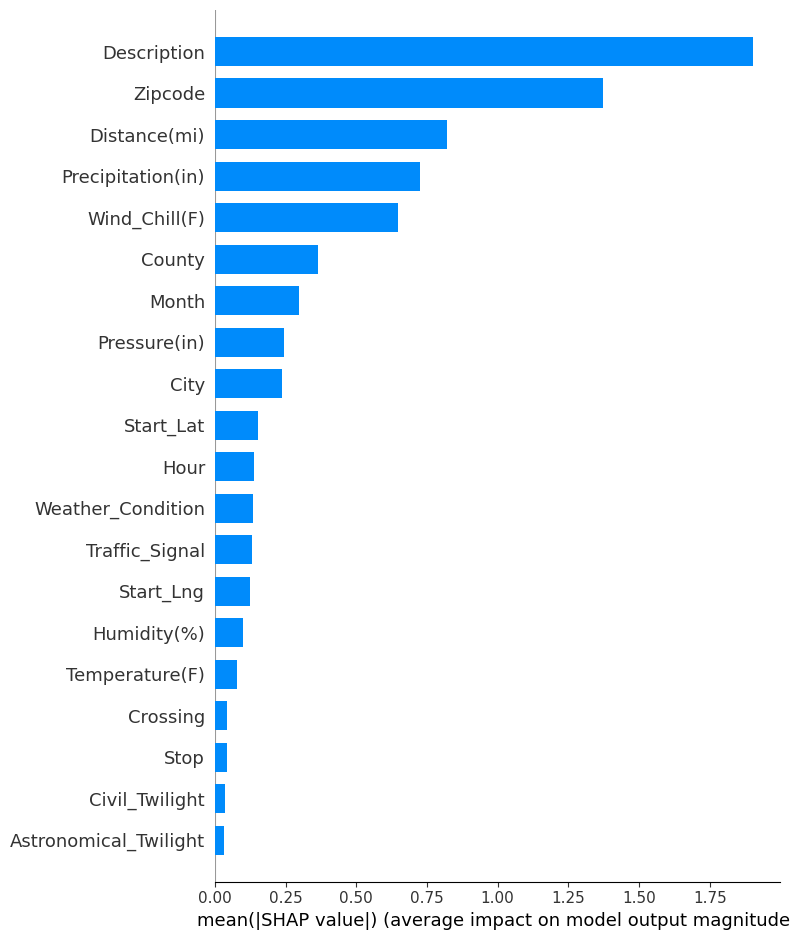

In [26]:
shap.summary_plot(shap_values, X_test_subset, plot_type="bar")

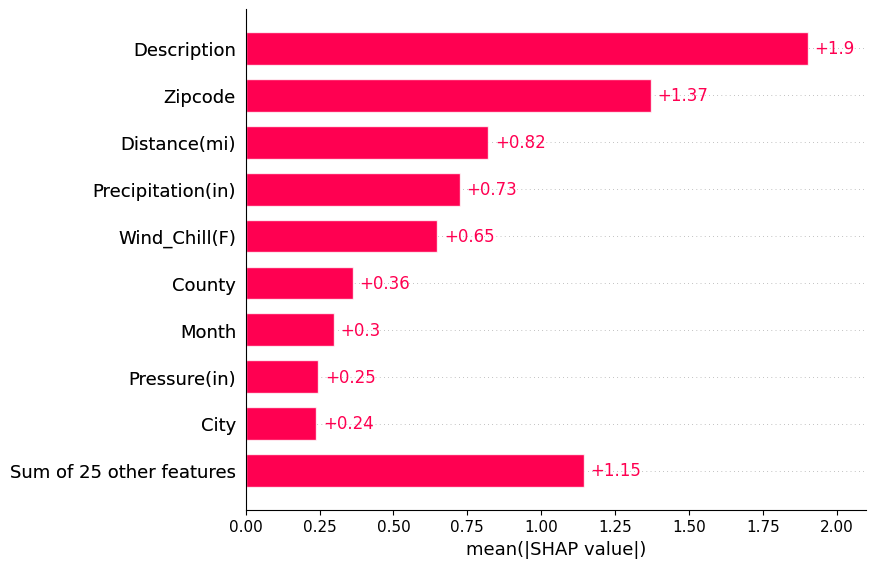

In [28]:
shap.plots.bar(shap_values)

In these three plots, Description and Zipcode are the most significant features in making the predictions for this model.

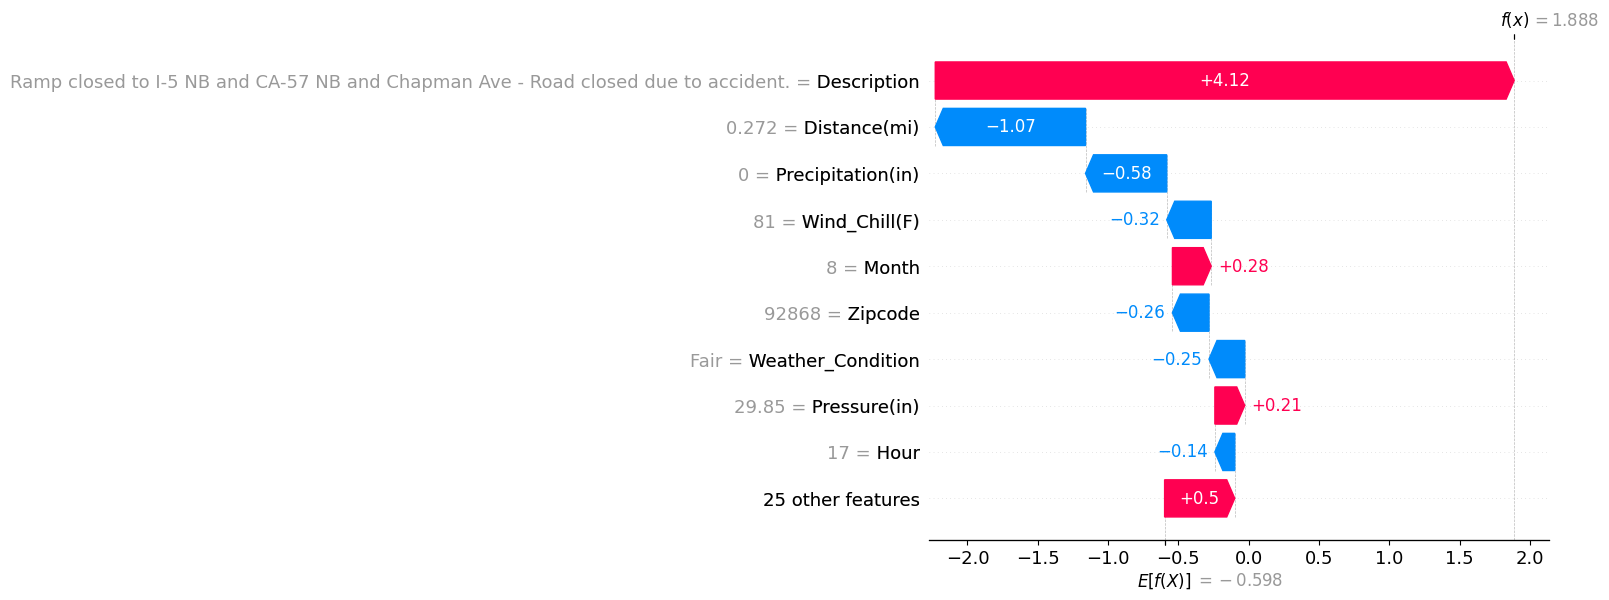

In [29]:
#waterfall plot for the 90 observation
#this is severe
shap.plots.waterfall(shap_values[90])

Here is a waterfall plot showing a single accident. We can see that Description has a positive SHAP value which means that its more likely that it's a severe accident and it is.

In [30]:
# cali_df[(cali_df['Distance(mi)'] == 0.272) & (cali_df['Pressure(in)'] == 29.85)]
cali_df[cali_df['ID'] == 'A-7773650']

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Duration,Month,Binary_Severity,Hour
1700368,7724282,A-7773650,4,2019-08-14 17:17:37,2019-08-14 17:47:00,33.77838,-117.8705,0.272,Ramp closed to I-5 NB and CA-57 NB and Chapman...,CA-22 W,Orange,Orange,CA,92868,2019-08-14 16:53:00,81.0,81.0,50.0,29.85,10.0,24.577115,0.0,Fair,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.489722,8,1,17


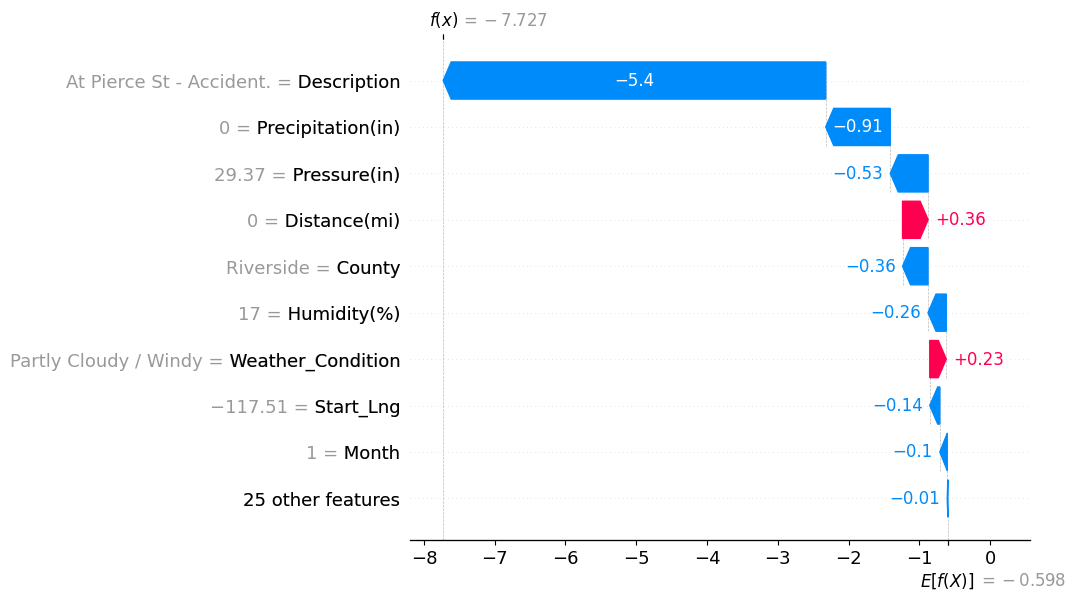

In [31]:
#waterfall plot for the 888 observation
#this is not severe
shap.plots.waterfall(shap_values[888])

Here is another waterfall plot showing another accident. We can see that Description has a negative SHAP value which means that its more likely that it's a non-severe accident.

In [ ]:
#looking up the accident above to confirm it's a non-severe accident
cali_df[(cali_df['Zipcode'] == '92879') & (cali_df['Pressure(in)'] == 29.37) & (cali_df['Description'] == 'At Pierce St - Accident.')]

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Duration,Month,Binary_Severity,Hour
1524871,7193637,A-7242998,2,2020-01-29 16:53:00,2020-01-29 17:28:29,33.88999,-117.50985,0.0,At Pierce St - Accident.,CA-91 E,Corona,Riverside,CA,92879,2020-01-29 16:56:00,68.0,68.0,17.0,29.37,9.0,24.577115,0.0,Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.591389,1,0,16
1524885,7193651,A-7243012,2,2020-01-29 16:48:00,2020-01-29 17:47:27,33.88998,-117.50985,0.0,At Pierce St - Accident.,CA-91 E,Corona,Riverside,CA,92879,2020-01-29 16:56:00,68.0,68.0,17.0,29.37,9.0,24.577115,0.0,Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.990833,1,0,16
1537902,7217565,A-7266926,2,2020-02-17 12:01:00,2020-02-17 12:55:08,33.88998,-117.50985,0.0,At Pierce St - Accident.,CA-91 E,Corona,Riverside,CA,92879,2020-02-17 11:56:00,68.0,68.0,50.0,29.37,10.0,24.577115,0.0,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.902222,2,0,12


In [8]:
cali_df['Wind_Chill(F)'].describe()

count    1.700851e+06
mean     6.331079e+01
std      1.241733e+01
min     -2.800000e+01
25%      5.700000e+01
50%      6.473455e+01
75%      6.800000e+01
max      2.070000e+02
Name: Wind_Chill(F), dtype: float64

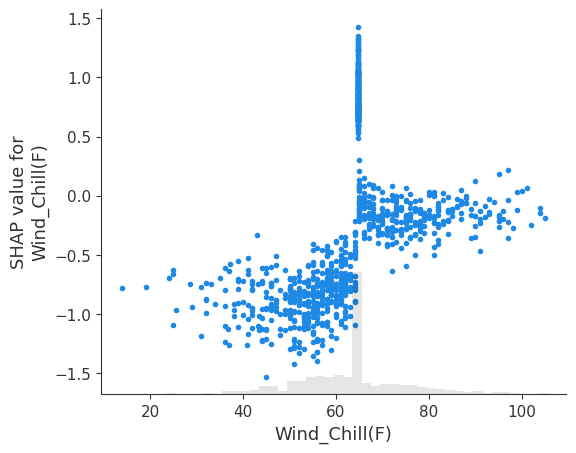

In [32]:
shap.plots.scatter(shap_values[:,"Wind_Chill(F)"])

The light grey area at the bottom of the plot is a histogram showing the distribution of data values for Wind Chill.


The SHAP values for the temperatures in the middle of the distribution are much higher compared to the temperatures on the opposite ends, indicating that these accidents are more severe. This observation is consistent with the beeswarm plot above.

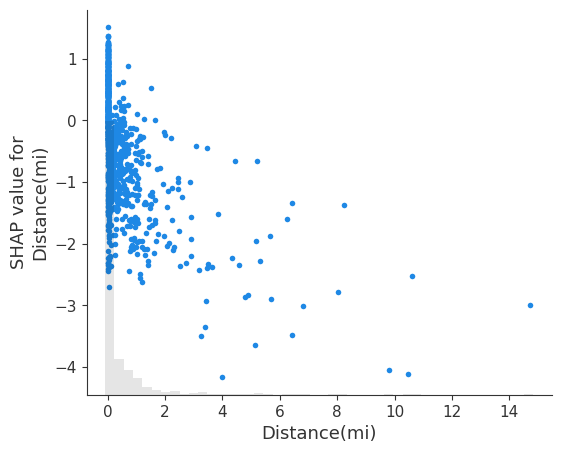

In [33]:
shap.plots.scatter(shap_values[:,"Distance(mi)"])

The larger Distance(mi) points have smaller SHAP values, indicating that they are more likely to be associated with non-severe accidents.

In [13]:
cali_df['Precipitation(in)'].describe()

count    1.700851e+06
mean     5.415768e-03
std      3.054884e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.342249e-03
max      2.400000e+01
Name: Precipitation(in), dtype: float64

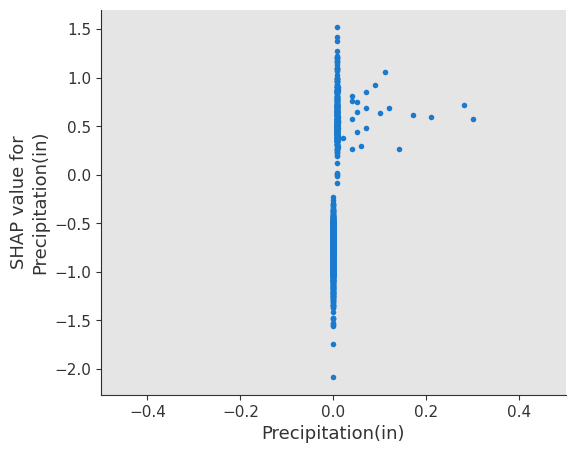

In [34]:
shap.plots.scatter(shap_values[:,"Precipitation(in)"])

You can observe that the two lines are not perfectly aligned. The top line is slightly shifted to the right, having a higher SHAP value. This corresponds to the Precipitation feature in the beeswarm plot above.

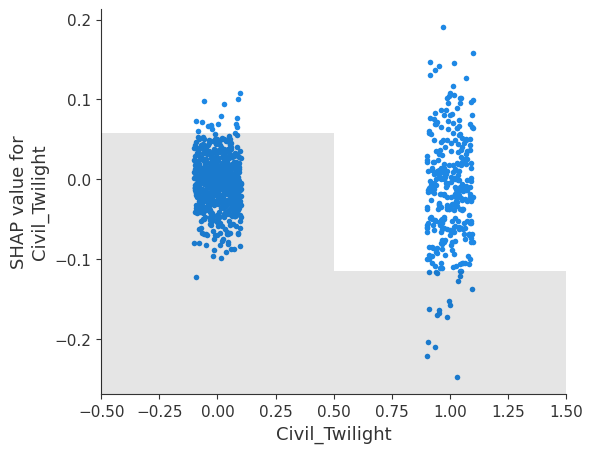

In [35]:
shap.plots.scatter(shap_values[:,"Civil_Twilight"])

The values for Civil Twilight are binary, either 0 or 1. The SHAP values mostly fall within the range of -1 to 1. It's difficult to determine the classification for each data point based solely on this feature. To make a conclusive determination, we would need to look into other features as well.

# Conclusion

I recommend the DOT begin at the following cities as they have the highest severity percentage among the other cities:

> Baldwin Park

> Oakland

> Long Beach



To end off, severe accidents are not primarily caused by weather-related conditions, road features, or the time and twilight periods. It may be necessary to investigate other potential causes. While these factors may not be the primary contributors, any percentage of accidents is still concerning and warrants attention.